<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/TeamProject_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Review with Video https://www.youtube.com/watch?v=hpfQE0bTeA4

In [1]:
pip install pandas_ta

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings


"""#Now build the model"""

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

pd.set_option('display.max_columns', None)




In [67]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 150,
                 start_date = '2012-03-11',
                 end_date='2022-07-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.batch_size     = batch_size
        self.epochs         = epochs
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])

        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()

        if self.run_all:
          self.Run_All()


    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        sc = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to oour data to make it between 0 and `
        self.data_set_scaled = sc.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]


        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        lstm_input = Input(shape=(self.frame_days, len(self.X[0][0])), name='lstm_input')      # Input layer
        inputs = LSTM(self.lstm_layers, name='first_layer')(lstm_input)                        # Long Short Term memory  wiht 150 layers
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        #self.model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])                  # Compile model
        self.model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])   # Compile model



    def Fit(self):
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=True,
                       validation_data=(self.X_test, self.y_test))
                       #validation_split = 0.1)


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)
        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          self.pred_diff[i]    = Predicted/Actual
          self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
          if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
            self.pred_correctness[i] = True;
          else: self.pred_correctness[i] = False;

    def View_Performance_Report(self,show_graphs=True):
        #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

         # R^2    = ?????


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print("")

        #Plot Graph
        if (show_graphs == True):

          plt.figure(figsize=(12, 6))

          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['accuracy'])
          plt.plot(self.history.history['val_accuracy'])
          plt.title('Model Accuracy')
          plt.ylabel('Accuracy')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')

          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')

          plt.show()


          plt.figure(figsize=(16,8))
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()



    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()

    def Run_All(self):
      self.View_Performance_Report()




In [62]:
# Varables
Indicators    = '^DJI,^BSESN,^BVSP'
Ticker        = 'XOM'
Frame_Days    =  10
LSTM_Layers   = 150


In [66]:
Indicators    = '^DJI,^BSESN,^BVSP'
Ticker        = 'ADM'
LSTM_Layers   = 50
ADM_F10_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers, run=True)
ADM_F30_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers, run=True)
ADM_F50_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers, run=True)
LSTM_Layers   = 150
ADM_F10_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers, run=True)
ADM_F30_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers, run=True)
ADM_F50_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers, run=True)
LSTM_Layers  = 250
ADM_F10_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers, run=True)
ADM_F30_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers, run=True)
ADM_F50_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers, run=True)

Ticker        = 'MSI'
LSTM_Layers   = 50
MSI_F10_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers, run=True)
MSI_F30_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers, run=True)
MSI_F50_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers, run=True)
LSTM_Layers   = 150
MSI_F10_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers, run=True)
MSI_F30_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers, run=True)
MSI_F50_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers, run=True)
LSTM_Layers  = 250
MSI_F10_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers, run=True)
MSI_F30_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers, run=True)
MSI_F50_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers, run=True)

Ticker        = 'XOM'
LSTM_Layers   = 50
XOM_F10_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers, run=True)
XOM_F30_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers, run=True)
XOM_F50_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers, run=True)
LSTM_Layers   = 150
XOM_F10_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers, run=True)
XOM_F30_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers, run=True)
XOM_F50_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers, run=True)
LSTM_Layers  = 250
XOM_F10_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers, run=True)
XOM_F30_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers, run=True)
XOM_F50_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers, run=True)


[*********************100%%**********************]  4 of 4 completed
<ipython-input-61-08f5efb1d8c9>:84: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


Epoch 1/30
122/122 [==============================] - 7s 13ms/step - loss: 0.5030 - accuracy: 5.4795e-04 - val_loss: 0.6863 - val_accuracy: 0.0022
Epoch 2/30
122/122 [==============================] - 1s 8ms/step - loss: 0.5468 - accuracy: 5.4795e-04 - val_loss: 0.8115 - val_accuracy: 0.0000e+00
Epoch 3/30
122/122 [==============================] - 1s 9ms/step - loss: 0.4845 - accuracy: 5.4795e-04 - val_loss: 0.7054 - val_accuracy: 0.0000e+00
Epoch 4/30
122/122 [==============================] - 1s 9ms/step - loss: 0.4773 - accuracy: 5.4795e-04 - val_loss: 0.7106 - val_accuracy: 0.0022
Epoch 5/30
122/122 [==============================] - 1s 8ms/step - loss: 0.4771 - accuracy: 5.4795e-04 - val_loss: 0.7075 - val_accuracy: 0.0022
Epoch 6/30
122/122 [==============================] - 1s 8ms/step - loss: 0.4771 - accuracy: 5.4795e-04 - val_loss: 0.7070 - val_accuracy: 0.0022
Epoch 7/30
122/122 [==============================] - 1s 8ms/step - loss: 0.4769 - accuracy: 5.4795e-04 - val_loss:

<ipython-input-61-08f5efb1d8c9>:169: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.pred_diff[i]    = Predicted/Actual
<ipython-input-61-08f5efb1d8c9>:170: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.pred_diff_bias[i]  = 1 - (Predicted/Actual)


'\nADM_F30_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers,).Run_All()\nADM_F50_L50 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers,).Run_All()\nLSTM_Layers   = 150\nADM_F10_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers,).Run_All()\nADM_F30_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers,).Run_All()\nADM_F50_L150 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers,).Run_All()\nLSTM_Layers  = 250\nADM_F10_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=10,lstm_layers=LSTM_Layers,).Run_All()\nADM_F30_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=30,lstm_layers=LSTM_Layers,).Run_All()\nADM_F50_L200 = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=50,lstm_layers=LSTM_Layers,).Run_All()\n'

############################################################################
  Model Setup:
                    Name: ADM_F10_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.12542765124059144
             mean_sqr_err =0.02436853896306143
        root_mean_sqr_err =0.15610425671025577
           pred_diff_mean =0.79753398608607
      pred_diff_bias_mean =0.20246601391393002
    pred_correctness_mean =0.3938730853391685



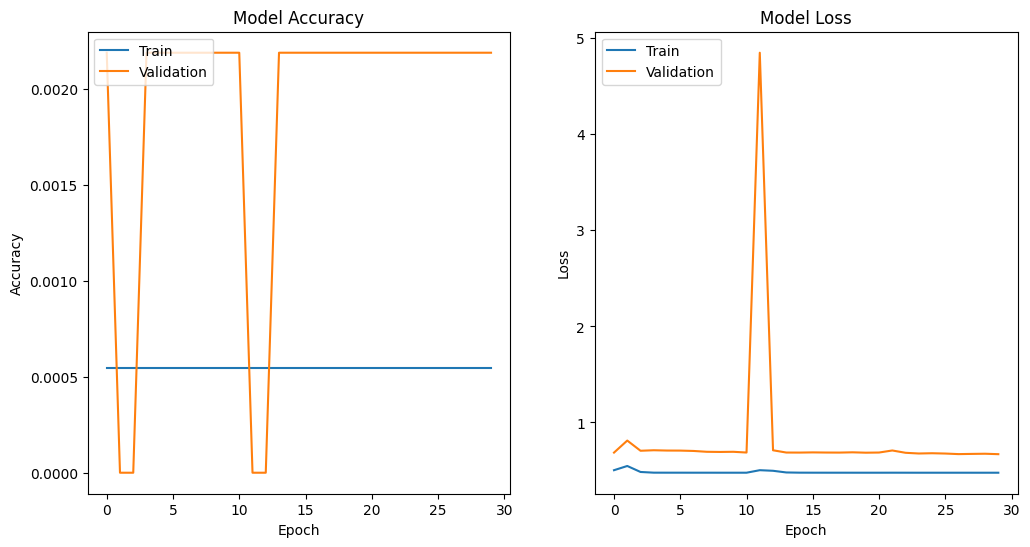

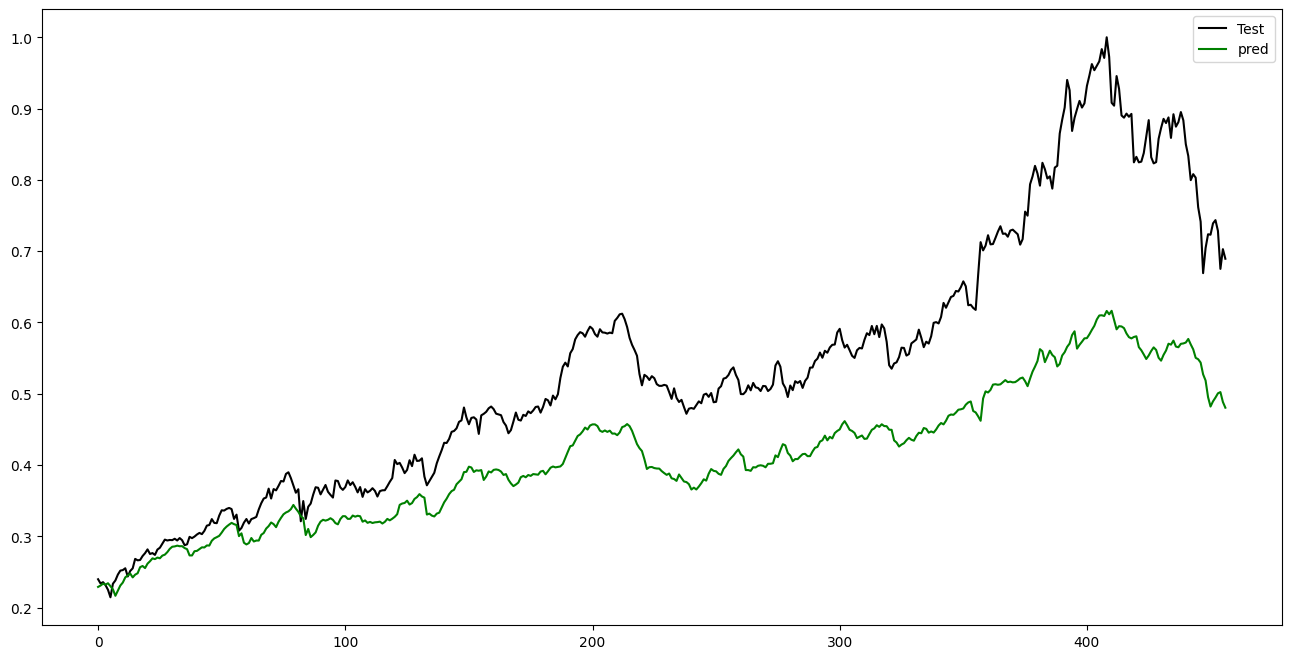

In [68]:
ADM_F10_L50.View_Performance_Report(show_graphs=True)
ADM_F30_L50.View_Performance_Report(show_graphs=True)
ADM_F50_L50.View_Performance_Report(show_graphs=True)
ADM_F10_L150.View_Performance_Report(show_graphs=True)
ADM_F30_L150.View_Performance_Report(show_graphs=True)
ADM_F50_L150.View_Performance_Report(show_graphs=True)
ADM_F10_L200.View_Performance_Report(show_graphs=True)
ADM_F30_L200.View_Performance_Report(show_graphs=True)
ADM_F50_L200.View_Performance_Report(show_graphs=True)
MSI_F10_L50.View_Performance_Report(show_graphs=True)
MSI_F30_L50.View_Performance_Report(show_graphs=True)
MSI_F50_L50.View_Performance_Report(show_graphs=True)
MSI_F10_L150.View_Performance_Report(show_graphs=True)
MSI_F30_L150.View_Performance_Report(show_graphs=True)
MSI_F50_L150.View_Performance_Report(show_graphs=True)
MSI_F10_L200.View_Performance_Report(show_graphs=True)
MSI_F30_L200.View_Performance_Report(show_graphs=True)
MSI_F50_L200.View_Performance_Report(show_graphs=True)
XOM_F10_L50.View_Performance_Report(show_graphs=True)
XOM_F30_L50.View_Performance_Report(show_graphs=True)
XOM_F50_L50.View_Performance_Report(show_graphs=True)
XOM_F10_L150.View_Performance_Report(show_graphs=True)
XOM_F30_L150.View_Performance_Report(show_graphs=True)
XOM_F50_L150.View_Performance_Report(show_graphs=True)
XOM_F10_L200.View_Performance_Report(show_graphs=True)
XOM_F30_L200.View_Performance_Report(show_graphs=True)
XOM_F50_L200.View_Performance_Report(show_graphs=True)


[*********************100%%**********************]  2 of 2 completed
<ipython-input-49-ad259ba4c602>:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


Epoch 1/30
124/124 [==============================] - 6s 21ms/step - loss: 0.7038 - accuracy: 0.0000e+00 - val_loss: 0.5960 - val_accuracy: 0.0049
Epoch 2/30
124/124 [==============================] - 3s 24ms/step - loss: 0.6849 - accuracy: 0.0000e+00 - val_loss: 0.5826 - val_accuracy: 0.0049
Epoch 3/30
124/124 [==============================] - 3s 21ms/step - loss: 0.6845 - accuracy: 0.0000e+00 - val_loss: 0.5735 - val_accuracy: 0.0049
Epoch 4/30
124/124 [==============================] - 2s 19ms/step - loss: 0.6844 - accuracy: 0.0000e+00 - val_loss: 0.5709 - val_accuracy: 0.0049
Epoch 5/30
124/124 [==============================] - 4s 35ms/step - loss: 0.6843 - accuracy: 0.0000e+00 - val_loss: 0.5703 - val_accuracy: 0.0049
Epoch 6/30
124/124 [==============================] - 2s 16ms/step - loss: 0.6843 - accuracy: 0.0000e+00 - val_loss: 0.5694 - val_accuracy: 0.0049
Epoch 7/30
124/124 [==============================] - 2s 19ms/step - loss: 0.6843 - accuracy: 0.0000e+00 - val_loss: 0

<ipython-input-49-ad259ba4c602>:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.pred_diff[i]    = Predicted/Actual
<ipython-input-49-ad259ba4c602>:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.pred_diff_bias[i]  = 1 - (Predicted/Actual)


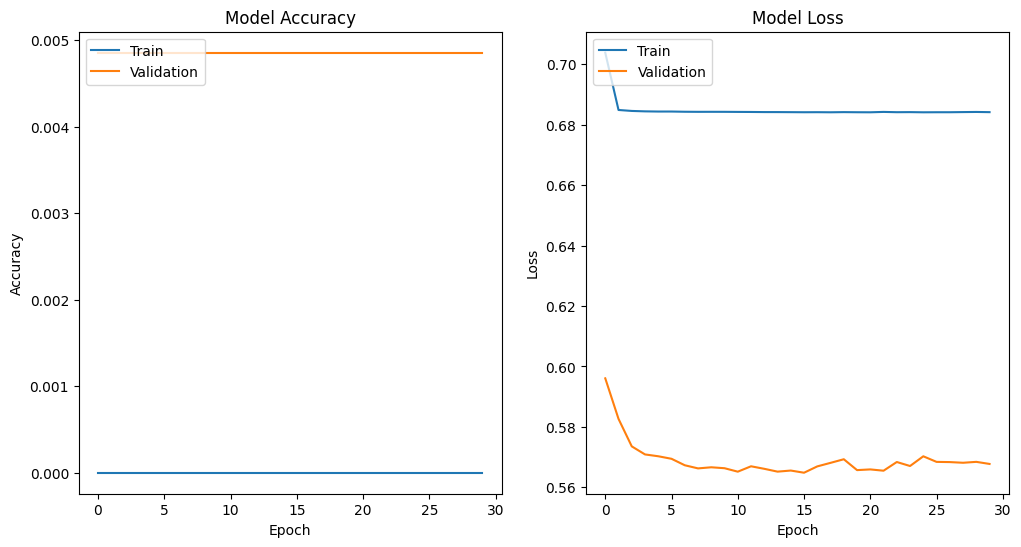

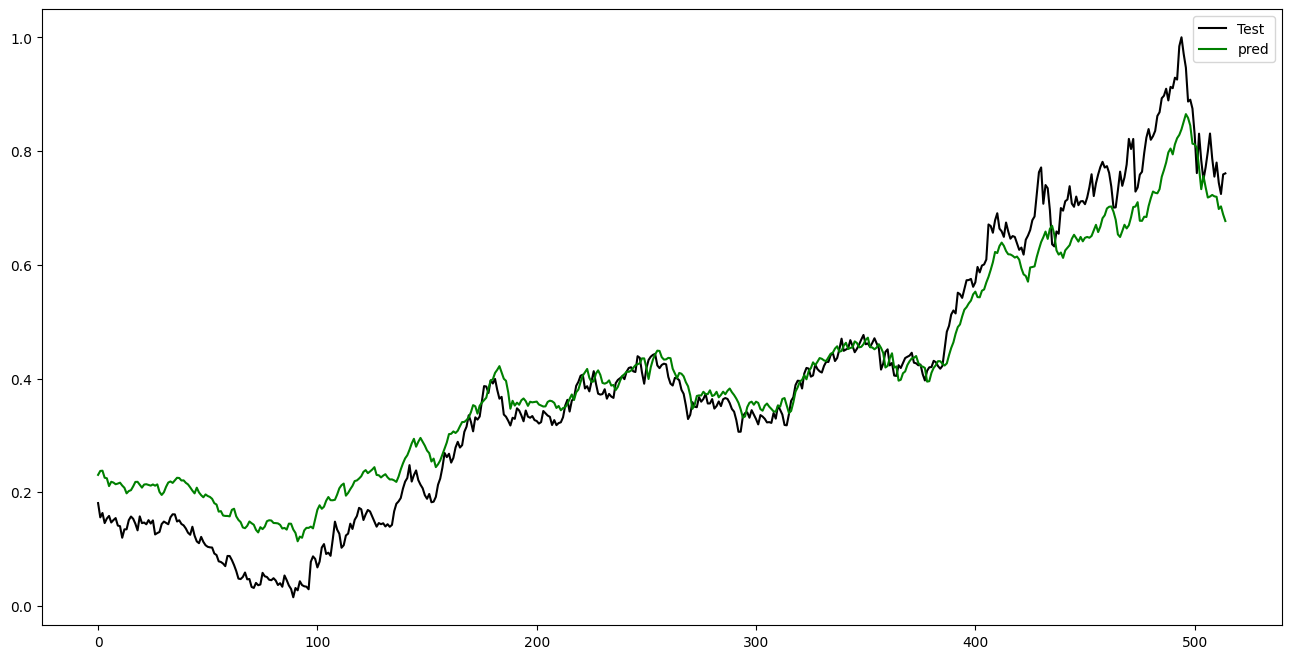

In [50]:
adm_model = MyLSTMModel(indicators= Indicators, ticker=Ticker,frame_days=Frame_Days,lstm_layers=LSTM_Layers,)
adm_model.Run_All()
adm_model.View_Performance_Report(show_graphs=True)


